In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from IPython.core.pylabtools import figsize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve,accuracy_score,recall_score

In [2]:
df = pd.read_csv("C:/Documents/churn data sample.csv")
print("Dataset shape:", df.shape)

Dataset shape: (71047, 72)


In [3]:
df.drop(columns=["Unnamed: 0","X"],inplace=True)
df.head()

,customer,traintest,churn,churndep,revenue,mou,recchrge,directas,overage,roam,...,retaccpt,newcelly,newcelln,refer,incmiss,income,mcycle,setprcm,setprc,retcall
0,1000002,0,0,NaN,57.492500,482.75,37.424999,0.2475,22.75,0.0,...,0,0,1,0,0,5,0,0,149.989990,0
1,1000006,0,0,NaN,82.275002,1312.25,75.000000,1.2375,0.00,0.0,...,0,1,0,0,0,6,0,0,9.989998,0
2,1000010,0,0,NaN,31.662500,25.50,29.990000,0.2475,0.00,0.0,...,0,0,1,0,0,9,0,0,29.989990,0
3,1000011,0,0,NaN,62.127499,97.50,65.985001,2.4750,0.00,0.0,...,0,1,0,0,0,6,0,0,29.989990,0
4,1000014,0,0,NaN,25.225000,2.50,25.000000,0.0000,0.00,0.0,...,0,1,0,0,0,7,0,0,29.989990,0


In [4]:
overall_churn = df["churn"].mean()
total_revenue = df["revenue"].sum()
churned_revenue = df.loc[df["churn"] == 1, "revenue"].sum()
revenue_weighted_churn = churned_revenue / total_revenue


print(f"Churn Rate: {overall_churn:.2%}")
print(f"Total Revenue: {total_revenue:.2f}")
print(f"Churned Revenue: {churned_revenue:.2f}")
print(f"Revenue-Weighted Churn Rate: {revenue_weighted_churn:.2%}")

Churn Rate: 29.01%
Total Revenue: 4168602.88
Churned Revenue: 1188362.96
Revenue-Weighted Churn Rate: 28.51%


In [5]:
df["tenure_cohort"] = pd.cut(
    df["months"],
    bins=[0, 6, 12, 24, 48, 100],
    labels=["0-6", "6-12", "12-24", "24-48", "48+"])

print(df["tenure_cohort"])

cohort_analysis = (
    df.groupby("tenure_cohort",observed=False)
      .agg(
          customers=("customer", "count"),
          churn_count=("churn", lambda x: x[df.loc[x.index, "churn"] == 1].sum()),
          total_revenue=("revenue", "sum"),
          churned_revenue=("revenue",
                            lambda x: x[df.loc[x.index, "churn"] == 1].sum())
      )
)
print(cohort_analysis.round(2))


0          48+
1          48+
2          48+
3          48+
4          48+
         ...  
71042    24-48
71043    24-48
71044    24-48
71045    24-48
71046    24-48
Name: tenure_cohort, Length: 71047, dtype: category
Categories (5, object): ['0-6' < '6-12' < '12-24' < '24-48' < '48+']
               customers  churn_count  total_revenue  churned_revenue
tenure_cohort                                                        
0-6                  994          196       63151.76         13913.13
6-12               22581         6112     1336822.56        364889.93
12-24              29907         9236     1750766.19        537895.28
24-48              16762         4866      966112.37        259093.11
48+                  803          199       51750.00         12571.51


In [6]:
cohort_analysis["revenue_weighted_churn"] = (
    cohort_analysis["churned_revenue"] / cohort_analysis["total_revenue"]*100
)

print("\nCohort Churn Analysis:")
print(cohort_analysis.round(2).to_string())


Cohort Churn Analysis:
               customers  churn_count  total_revenue  churned_revenue  revenue_weighted_churn
tenure_cohort                                                                                
0-6                  994          196       63151.76         13913.13                   22.03
6-12               22581         6112     1336822.56        364889.93                   27.30
12-24              29907         9236     1750766.19        537895.28                   30.72
24-48              16762         4866      966112.37        259093.11                   26.82
48+                  803          199       51750.00         12571.51                   24.29


In [7]:
drop_cols = ["customer", "churn", "revenue", "tenure_cohort","churndep"]
X = df.drop(columns=drop_cols)
y = df["churn"]


X_train, X_test, y_train, y_test = train_test_split( X, y,
    test_size=0.25,
    stratify=y,
    random_state=42)

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_pipline=Pipeline(steps=[("imputer",SimpleImputer(strategy="median")),
                            ("scaler",StandardScaler())])

cat_pipline=Pipeline(steps=[('imputer',SimpleImputer(strategy="most_frequent")),
    ('encoder',OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipline, num_features),
        ("cat", cat_pipline, cat_features)])

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced")

pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", model)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]
print(y_prob.round(2))

[0.08 0.04 0.83 ... 0.68 0.05 0.75]


In [20]:
print("\nClassification Report:")
report=(classification_report(y_test, y_pred))
print(report)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

score = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", score)




Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.76     12610
           1       0.51      0.95      0.66      5152

    accuracy                           0.72     17762
   macro avg       0.74      0.79      0.71     17762
weighted avg       0.84      0.72      0.73     17762

Accuracy: 0.719626168224299
Recall: 0.9549689440993789
ROC-AUC Score: 0.8366350648455086


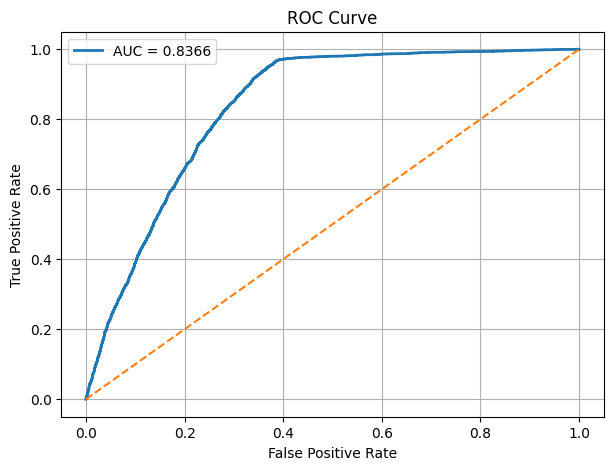

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(7,5))

plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {score:.4f}")

# Diagonal line = Random Model
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

plt.show()


In [11]:
test_revenue = df.loc[X_test.index, "revenue"]

expected_revenue_loss = np.sum(y_prob * test_revenue)
actual_churned_revenue = test_revenue[y_test == 1].sum()

revenue_capture_ratio = expected_revenue_loss / actual_churned_revenue

print(f"\nExpected Revenue Loss (Predicted): {expected_revenue_loss:,.2f}")
print(f"Actual Churned Revenue: {actual_churned_revenue:,.2f}")
print(f"Revenue Capture Ratio: {revenue_capture_ratio:.2%}")


Expected Revenue Loss (Predicted): 420,935.47
Actual Churned Revenue: 295,436.13
Revenue Capture Ratio: 142.48%


In [12]:
risk_table = pd.DataFrame({
    "CustomerIndex": X_test.index,
    "ChurnProbability": y_prob,
    "MonthlyRevenue": test_revenue
})

print(risk_table.round(2))



       CustomerIndex  ChurnProbability  MonthlyRevenue
14292          14292              0.08            5.00
6226            6226              0.04           58.17
31429          31429              0.83           50.36
60791          60791              0.75           81.93
17100          17100              0.05           58.74
...              ...               ...             ...
23308          23308              0.04           51.98
56053          56053              0.75             NaN
45149          45149              0.68           39.65
18324          18324              0.05           35.83
40573          40573              0.75           54.11

[17762 rows x 3 columns]


In [13]:
risk_table["ExpectedLoss"] = (
    risk_table["ChurnProbability"] * risk_table["MonthlyRevenue"]
)

top_risk_customers = risk_table.sort_values(
    "ExpectedLoss", ascending=False
).head(20)

print("\nTop 20 High Revenue-Risk Customers:")
print(top_risk_customers)


Top 20 High Revenue-Risk Customers:
       CustomerIndex  ChurnProbability  MonthlyRevenue  ExpectedLoss
31392          31392          0.970051      793.049988    769.299128
37874          37874          0.965686      776.270019    749.632894
45408          45408          0.923118      672.015015    620.349001
61088          61088          0.953185      575.750000    548.796179
42235          42235          0.881369      584.224976    514.917633
47735          47735          0.891610      503.904999    449.286541
66629          66629          0.733321      523.202515    383.675213
39308          39308          0.930895      411.897492    383.433450
50221          50221          0.829098      457.209992    379.071913
44254          44254          0.908576      413.105011    375.337359
55625          55625          0.876916      382.832489    335.711805
38005          38005          0.845277      376.882507    318.570176
46910          46910          0.866883      344.737488    298.8470

In [14]:
summary = pd.DataFrame({
    "Churn Rate": [overall_churn],
    "Total_Revenue": [total_revenue],
    "Churned_Revenue": [churned_revenue],
    "Revenue_Weighted_Churn": [revenue_weighted_churn],
    "ROC-AUC Score":[score],
    "expected_revenue_loss":[expected_revenue_loss]
})

summary.to_csv("Revenue_Summary.csv", index=False)


cohort_analysis.to_csv("CohortAnalysis.csv")

predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted_Class": y_pred,
    "Predicted_Probability": y_prob
})

predictions_df.to_csv("Model_Predictions.csv", index=False)
